<a href="https://colab.research.google.com/github/giorgioGunawan/neural_tangent_kernels/blob/master/NTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Utils

In [17]:
!pip install -q git+https://www.github.com/google/neural-tangents

import jax.numpy as np

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

In [18]:
def loss_fn(predict_fn, ys, t, xs=None):
  mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
  mean = np.reshape(mean, mean.shape[:1] + (-1,))
  var = np.diagonal(cov, axis1=1, axis2=2)
  ys = np.reshape(ys, (1, -1))

  mean_predictions = 0.5 * np.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

  return mean_predictions


train_points = 5
test_points = 50
noise_scale = 1e-1

target_fn = lambda x: np.sin(x)
key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-np.pi, maxval=np.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)
test_xs = np.linspace(-np.pi, np.pi, test_points)
test_xs = np.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

# DEFINE NEURAL NETWORK



In [19]:
init_fn, apply_fn, kernel_fn = stax.serial(
    #stax.Dense(512, W_std=1, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1, b_std=0.01), stax.Erf(),
    stax.Dense(1, W_std=1, b_std=0.05)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))
kernel = kernel_fn(test_xs, test_xs, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

## Infinite Width Inference

In [20]:
my_train_xs = np.array([[0.2758620689655173, 0.522167487684729],
 [0.3128078817733991, 0.458128078817734],
 [0.3497536945812808, 0.3251231527093596],
 [0.3990147783251232, 0.23152709359605914],
 [0.44581280788177347, 0.17733990147783257],
 [0.48522167487684725, 0.0],
 [0.20689655172413793, 0.47290640394088673],
 [0.23152709359605914, 0.3201970443349755],
 [0.2733990147783251, 0.2807881773399015],
 [0.32266009852216754, 0.2758620689655173],
 [0.374384236453202, 0.2167487684729064],
 [0.42118226600985226, 0.06896551724137938],
 [0.13300492610837442, 0.42364532019704443],
 [0.16502463054187191, 0.33004926108374383],
 [0.20689655172413793, 0.28571428571428575],
 [0.2561576354679803, 0.19704433497536955],
 [0.29802955665024633, 0.11330049261083744],
 [0.3620689655172413, 0.0591133004926109],
 [0.06650246305418721, 0.37931034482758624],
 [0.08866995073891623, 0.28571428571428575],
 [0.1502463054187192, 0.22167487684729065],
 [0.19211822660098518, 0.15763546798029562],
 [0.2413793103448276, 0.08374384236453199],
 [0.2832512315270936, 0.02955665024630545],
 [0.0, 0.42857142857142866],
 [0.034482758620689634, 0.30541871921182273],
 [0.09359605911330048, 0.2561576354679803],
 [0.13054187192118222, 0.16256157635467985],
 [0.17980295566502463, 0.009852216748768483],
 [0.22660098522167488, 0.004926108374384242]])

my_train_ys = np.array([[14.847],
 [13.6878],
 [12.639],
 [11.507399999999999],
 [10.375799999999998],
 [9.189],
 [14.847],
 [13.6602],
 [12.5562],
 [11.4522],
 [10.3482],
 [9.189],
 [14.8746],
 [13.715399999999999],
 [12.583799999999998],
 [11.535],
 [10.431],
 [9.189],
 [14.8746],
 [13.6326],
 [12.6114],
 [11.4798],
 [10.375799999999998],
 [9.326999999999998],
 [14.7366],
 [13.715399999999999],
 [12.7494],
 [11.617799999999999],
 [10.431],
 [9.382200000000001]])

my_test_xs = np.array([[0.3448275862068966, 0.4926108374384237],
 [0.4014778325123153, 0.5123152709359605],
 [0.4433497536945813, 0.4384236453201972],
 [0.47783251231527096, 0.26108374384236455],
 [0.5344827586206897, 0.29064039408867004],
 [0.5541871921182265, 0.08866995073891623]])

my_test_ys = np.array([[14.9022],
 [13.742999999999999],
 [12.639],
 [11.535],
 [10.5414],
 [9.409799999999997]])




# Run intermediary to train


In [21]:

predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, my_train_xs, 
                                                      my_train_ys, diag_reg=1e-4)

nngp_mean, nngp_covariance = predict_fn(x_test= my_test_xs, get='nngp', 
                                        compute_cov=True)

nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))
train = (my_train_xs, my_train_ys)
test = (my_test_xs, my_test_ys)
ntk_mean, ntk_covariance = predict_fn(x_test=my_test_xs, get='ntk', 
                                      compute_cov=True)
ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance))



# CHECK RESULTS - NTK


In [22]:
##plot_fn(train, test)

#plt.plot(my_test_xs, nngp_mean, 'r-', linewidth=3)
"""plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)"""

#print(ntk_mean)
#print(my_test_ys)
"""
plt.plot(my_test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)"""
#plt.xlim([-np.pi, np.pi])
#plt.ylim([-1.5, 1.5])
"""
legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')"""
mae_ntk= 0
mae_nngp = 0
for i in range(len(ntk_mean)):
  mae_ntk += abs(ntk_mean[i] - my_test_ys[i][0])
  mae_nngp += abs(nngp_mean[i] - my_test_ys[i][0])
print((mae_ntk/6))

#finalize_plot((0.85, 0.6))

0.34486455


# CHECK RESULTS - NNGP


In [23]:
print((mae_nngp/6))

0.3447393


*HERE WE TRY EMPIRICAL NTK*


# EXPERIMENTAL SECTION


In [100]:
from neural_tangents import empirical_ntk_fn
from neural_tangents import predict
from jax import random
import neural_tangents as nt
from neural_tangents import stax

key1, key2, key3 = random.split(random.PRNGKey(1), 3)
x_train = random.normal(key1, (20, 32, 32, 3))
y_train = random.uniform(key1, (20, 10))
x_test = random.normal(key2, (5, 32, 32, 3))

print(x_train.size)
# A narrow CNN.
init_fn, f, _ = stax.serial(
      stax.Relu(),
      stax.Relu(),
      stax.Flatten(),
  )
t = 1e-7
learning_rate = 1e-2
momentum = 0.9
kernel_fn = empirical_ntk_fn(f)
k_test_train = kernel_fn(my_test_xs, my_train_xs, params)
print(k_test_train)

61440
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [ ]:
ts = np.arange(0, 10 ** 3, 10 ** -1)
ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

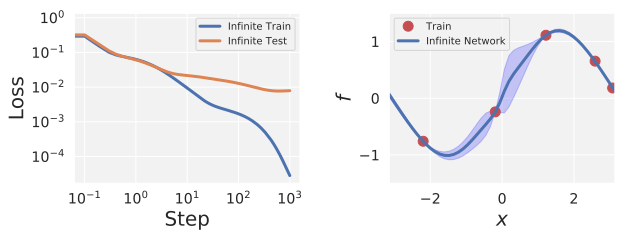

In [ ]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'], 
    loc='upper left')

finalize_plot((1.5, 0.6))

## Training a Neural Network

We will now compare the results of gradient descent GP-inference computed above to the result of training an ensemble of finite width neural networks. We first train a single network drawn from the prior and then we will show how to generalize this to an ensemble. To do this we use JAX's gradient descent [optimizer](https://github.com/google/jax#first-order-optimization). Optimizers are described by a triple of functions `(init_fn, update_fn, get_params)`. Here, `init_fn(params)` takes an initial set of parameters and returns an optimizer state that can include extra information (like the velocity in the `momentum` optimizer). `opt_update(step, grads, state)` takes a new state and updates it using gradients. Finally, `get_params(state)` returns the parameters for a given state.  

In [ ]:
learning_rate = 0.1
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

Next we need to define a loss and a gradient of the loss. We'll use an MSE loss. The function `grad` is another [JAX function](https://github.com/google/jax#automatic-differentiation-with-grad) that takes a function and returns a new function that computes its gradient.

In [ ]:
loss = jit(lambda params, x, y: 0.5 * np.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

Now we want to actually train the network. To do this we just initialize the optimizer state and then update it however many times we want. We'll record the train and test loss after each step.


In [ ]:
train_losses = []
test_losses = []

opt_state = opt_init(params)

for i in range(training_steps):
  opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses += [loss(get_params(opt_state), *train)]  
  test_losses += [loss(get_params(opt_state), *test)]

Finally, lets plot the loss over the course of training and the function after training compared with our GP inference.

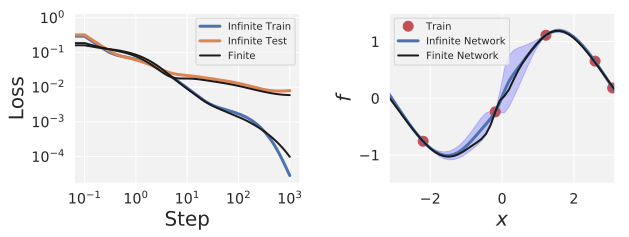

In [ ]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_losses, 'k-', linewidth=2)
plt.loglog(ts, test_losses, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(get_params(opt_state), test_xs), 'k-', linewidth=2)

legend(
    ['Train', 'Infinite Network', 'Finite Network'], 
    loc='upper left')

finalize_plot((1.5, 0.6))

## Training an Ensemble of Neural Networks

The draw above certainly seems consistent with exact inference. However, as discussed above to make a more quantitative comparison we want to train an ensemble of finite-width networks. We could use a for-loop to loop over all the different instantiations that we wanted to evaluate. However, it is more convenient and efficient to use another [JAX feature](https://github.com/google/jax#auto-vectorization-with-vmap) called `vmap`. `vmap` takes a function and vectorizes it over a batch dimension. In this case, we're going to add a batch dimension to our training loop so that we train a whole batch of neural networks at once. To do that, let's first wrap our whole training loop in a function. The function will take a random state and train a network based on that random state.

In [ ]:
def train_network(key):
  train_losses = []
  test_losses = []

  _, params = init_fn(key, (-1, 1)) 
  opt_state = opt_init(params)

  for i in range(training_steps):
    train_losses += [np.reshape(loss(get_params(opt_state), *train), (1,))]  
    test_losses += [np.reshape(loss(get_params(opt_state), *test), (1,))]
    opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses = np.concatenate(train_losses)
  test_losses = np.concatenate(test_losses)
  return get_params(opt_state), train_losses, test_losses

We can test it to make sure that we get a trained network.

In [ ]:
#@test {"skip": true}
params, train_loss, test_loss = train_network(key)

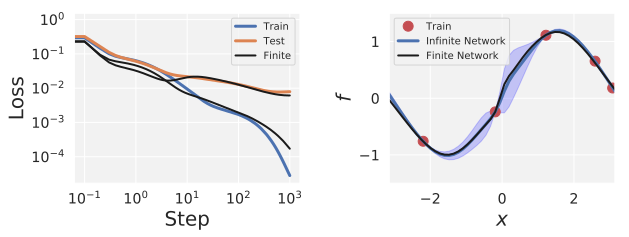

In [ ]:
#@test {"skip": true}
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_loss, 'k-', linewidth=2)
plt.loglog(ts, test_loss, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

Now, to train an ensemble we just have to apply `vmap` to `train_network`. The resulting function will take a vector of random states and will train one network for each random state in the vector.

In [ ]:
#@test {"skip": true}
ensemble_size = 100
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key) 

Let's plot the empirical standard deviation in the loss over the course of training as well as well as for the function after gradient descent compared with the exact inference above. 

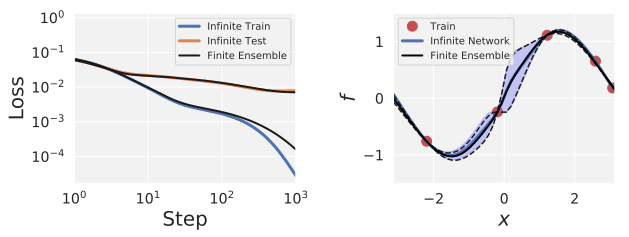

In [ ]:
#@test {"skip": true}
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))

We see pretty nice agreement between exact inference of the infinite-width networks and the result of training an ensemble! Note that we do see some deviations in the training loss at the end of training. This is ameliorated by using a wider network.

## Playing Around with the Architecture

To demonstrate the ease of specifying more exotic architecture, can try to reproduce the above results with different choices of architecture. For fn, let's see what happens if we add residual connections.

In [ ]:
ResBlock = stax.serial(
    stax.FanOut(2),
    stax.parallel(
        stax.serial(
            stax.Erf(),
            stax.Dense(512, W_std=1.1, b_std=0),
        ),
        stax.Identity()
    ),
    stax.FanInSum()
)

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1, b_std=0),
    ResBlock, ResBlock, stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

Given this new architecture, let's train a new ensemble of models.

In [ ]:
#@test {"skip": true}
ensemble_size = 100
learning_rate = 0.1
ts = np.arange(0, 10 ** 3, learning_rate)

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

key, = random.split(key, 1)
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key) 

Finally, let's repeat our NTK-GP inference

In [ ]:
#@test {"skip": true}
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs, 
                                                      train_ys, diag_reg=1e-4)
ntk_mean, ntk_var = predict_fn(x_test=test_xs, get='ntk', compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_var))

ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

Now let's draw the result!

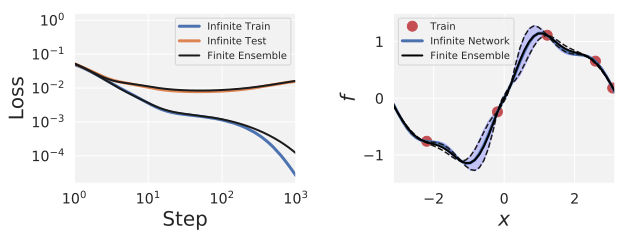

In [ ]:
#@test {"skip": true}
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))